# **Variational Autoencoder (VAE) for Cat Face Generation**

This notebook implements a convolutional Variational Autoencoder (VAE) to model 64×64 RGB cat faces.

## **Goals of this notebook**

- Load and preprocess the dataset  
- Build a VAE from scratch:
  - Convolutional encoder  
  - Latent space with mean and log-variance  
  - Reparameterization trick  
  - Convolutional decoder  
- Train the model using a reconstruction loss combined with a KL divergence term  
- Visualize:
  - Input images vs reconstructed images  
  - Novel samples generated from the latent space  
- Save the trained VAE for later comparison with GANs and Diffusion Models

## **Why start with a VAE?**

VAEs provide a smooth and structured latent space, making them useful for understanding how images can be compressed and reconstructed.  
They offer stable training and serve as a solid baseline before exploring more advanced generative models like GANs or Diffusion Models.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

In [9]:
# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## **Data Collection and Loading**

We load the 64×64 RGB cat face images from disk, resize them if needed, and store them in a NumPy array.  
Basic info (count, shape, value range) is displayed to confirm that the dataset is properly loaded.

In [ ]:
# Dataset URL from Kaggle (direct download)
# Note: You may need to download manually from:
# https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models

# For this exercise, we'll assume you have downloaded and extracted the dataset
data_dir = '../data/cats_dataset'  # Update this path to your dataset location


# If you have the dataset as a zip file, uncomment to extract:
with zipfile.ZipFile('../data/archive.zip', 'r') as zip_ref:
    zip_ref.extractall("../data")

print(f"Dataset directory: {data_dir}")

Dataset directory: cats_dataset


In [4]:
def load_cat_images(data_dir, max_images=None):
    """
    Load cat face images from directory
    Returns: numpy array of shape (n_samples, 64, 64, 3)
    """
    image_files = list(Path(data_dir).glob('*.jpg')) + list(Path(data_dir).glob('*.png'))
    
    if max_images:
        image_files = image_files[:max_images]
    
    images = []
    for img_path in image_files:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((64, 64))  # Ensure 64x64
        images.append(np.array(img))
    
    return np.array(images)


In [5]:
data_dir="cats_dataset/cats"
# Load images
images = load_cat_images(data_dir)
print(f"Loaded {len(images)} images")
print(f"Image shape: {images[1].shape}")
print(f"Data type: {images.dtype}")
print(f"Value range: [{images.min()}, {images.max()}]")

Loaded 15747 images
Image shape: (64, 64, 3)
Data type: uint8
Value range: [0, 255]


## **Data Visualization**

Below we display a few sample images from the dataset to verify that the data has been loaded correctly and to get a quick sense of the visual content we will train the model on.


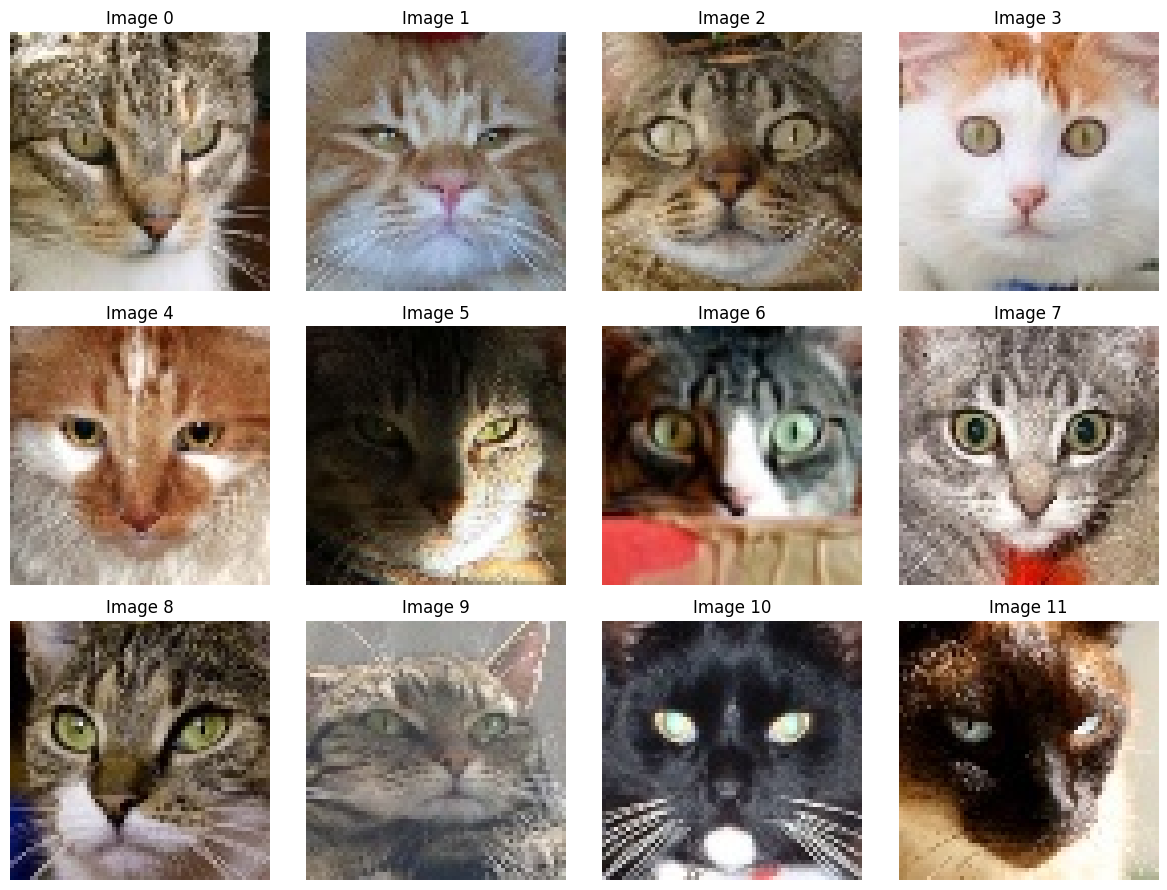

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(f'Image {i}')

plt.tight_layout()
plt.show()

## **Data Preparation**

Before training the VAE, we prepare the dataset of cat faces in two steps:

1. **Normalize the pixel values**  
   Neural networks train more effectively when inputs are scaled.  
   Here, we convert RGB values from the range `[0, 255]` to floating-point values in the range `[0, 1]`.

2. **Reorder image dimensions for PyTorch**  
   PyTorch expects images in the format **(channels, height, width)**.  
   The original data is loaded as **(height, width, channels)**, so we transpose the axes accordingly.

3. **Split the dataset into training and validation sets**  
   We use 90% of the images for training and keep the remaining 10% for validation.  
   This allows us to monitor generalization and detect overfitting.

In [8]:
# Normalize images to [0, 1]
images_norm = images.astype(np.float32) / 255.0

# Convert to PyTorch format: (N, C, H, W)
images_norm = images_norm.transpose(0, 3, 1, 2)

print("Normalized shape:", images_norm.shape)
print(f"Value range: [{images_norm.min():.3f}, {images_norm.max():.3f}]")

# Train / Validation split
split_idx = int(0.9 * len(images_norm))
train_images = images_norm[:split_idx]
val_images = images_norm[split_idx:]

print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")

Normalized shape: (15747, 3, 64, 64)
Value range: [0.000, 1.000]
Training samples: 14172
Validation samples: 1575


We convert the preprocessed NumPy arrays into PyTorch tensors and prepare efficient data pipelines for training the VAE.

### **Why we do this step**

Deep learning models in PyTorch expect batched tensors as input.  
To train the model properly, we need:

- A **TensorDataset**, which wraps our tensors into a dataset object PyTorch can iterate over.
- A **DataLoader**, which:
  - splits the dataset into **mini-batches**,
  - shuffles the data at each epoch (important for training stability),
  - loads batches efficiently during training.

### **What this achieves**

After this step, we will have:

- `train_loader` → batches of training images  
- `val_loader` → batches of validation images  

Both loaders output tensors of shape: (B, 3, 64, 64) where `B` is the batch size (here: 64).

These loaders will be used throughout training, reconstruction display, and generation.

In [10]:
# Convert numpy arrays → PyTorch tensors (float32)
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
val_images_tensor   = torch.tensor(val_images,   dtype=torch.float32)

# Wrap tensors into Dataset objects
train_dataset = TensorDataset(train_images_tensor)
val_dataset   = TensorDataset(val_images_tensor)

# DataLoader parameters
batch_size = 64

# Create PyTorch DataLoaders (batches + shuffling)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

## **VAE Architecture**

In this section, we implement the Variational Autoencoder (VAE) that will learn a compressed latent representation of cat faces and reconstruct them.

A VAE consists of three main parts:

### **1. Encoder**
- Takes an input image `(3 × 64 × 64)`
- Passes it through convolution layers to extract high-level features
- Flattens the feature map and outputs:
  - `μ` (mean of the latent distribution)
  - `logσ²` (log-variance of the latent distribution)

### **2. Reparameterization Trick**
Instead of sampling `z ~ N(μ, σ²)` directly (which breaks backprop),  
we compute:

$$[
z = \mu + \sigma \cdot \epsilon,\quad \epsilon \sim \mathcal{N}(0, I)
]$$

This allows gradient flow through the sampling step.

### **3. Decoder**
- Takes the latent vector `z`
- Projects it back into a spatial feature map
- Uses transpose convolutions to reconstruct a `3 × 64 × 64` image

### **Model Output**
The VAE returns:
- `x_recon` → reconstructed images  
- `μ` and `logσ²` → used to compute the KL divergence loss  

You will train the VAE to:
- minimize reconstruction error (MSE)
- regularize the latent space using KL divergence  

In [15]:

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU()
        )

        # Latent distribution parameters
        self.fc_mu = nn.Linear(64*16*16, latent_dim)
        self.fc_logvar = nn.Linear(64*16*16, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, latent_dim * 8 * 8)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self,x):
        h=self.encoder(x)
        #print(h.shape)
        x=h.view(h.size(0),-1)
        x_mu=self.fc_mu(x)
        x_logvar=self.fc_logvar(x)
        z=self.reparameterize(x_mu,x_logvar)
        h_dec=self.fc_decode(z)
        h_dec = h_dec.view(h_dec.size(0),z.size(1), 8, 8)    
        x_recon=self.decoder(h_dec)
        return x_recon, x_mu, x_logvar


## **Training setup and VAE loss**

We now instantiate the VAE model and define the training utilities:

- **`train_epoch`**: one full pass over the training set, using the VAE loss  
  (reconstruction MSE + KL divergence between the approximate posterior  
  $$(q_\phi(z \mid x))$$ and the prior $$(p(z) = \mathcal{N}(0, I))$$).
- **`evaluate`**: computes the same loss on the validation set, without gradients.
- **`train_model`**: runs several epochs, stores the train/validation losses and prints
  a short log at each epoch.
- **`plot_training_history`**: helper to visualise the loss curves.

In [16]:
# Initialize baseline model
Vae_model = VAE(latent_dim=128).to(device)

In [ ]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in loader:
        x=batch[0].to(device)

        #forward
        x_recon,mu,logvar=model(x)

        #reconstruction loss
        recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
        #KL loss
        KL_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        #total loss
        loss=0.1*KL_loss+recon_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss+=loss.item()
    return total_loss / len(loader)



def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in loader:
            x=batch[0].to(device)
            x_recon,mu,logvar=model(x)
            
            #reconstruction loss
            recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
            #KL loss
            KL_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            #total loss
            loss=0.1*KL_loss+recon_loss

            total_loss += loss.item()
    
    return total_loss / len(loader)

def train_model(model, train_loader, val_loader, device, epochs=30, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss = evaluate(model, val_loader, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    return history


def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(6,4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## **Training the VAE**

We train the VAE on the cat faces dataset for a fixed number of epochs and
monitor both the training and validation loss.  
The loss combines:

- a **reconstruction term** (MSE between input and output),
- a **KL divergence term** that regularises the latent space.

The plot below shows how these quantities evolve during training.

Epoch 1/10 - Train Loss: 334.1095 | Val Loss: 184.5674
Epoch 2/10 - Train Loss: 164.7895 | Val Loss: 146.1477
Epoch 3/10 - Train Loss: 139.5507 | Val Loss: 132.8067
Epoch 4/10 - Train Loss: 127.7847 | Val Loss: 123.1162
Epoch 5/10 - Train Loss: 121.8856 | Val Loss: 119.7944
Epoch 6/10 - Train Loss: 116.3684 | Val Loss: 118.0122
Epoch 7/10 - Train Loss: 113.4808 | Val Loss: 113.0452
Epoch 8/10 - Train Loss: 111.3989 | Val Loss: 110.9095
Epoch 9/10 - Train Loss: 108.9738 | Val Loss: 109.2881
Epoch 10/10 - Train Loss: 106.8495 | Val Loss: 107.9757


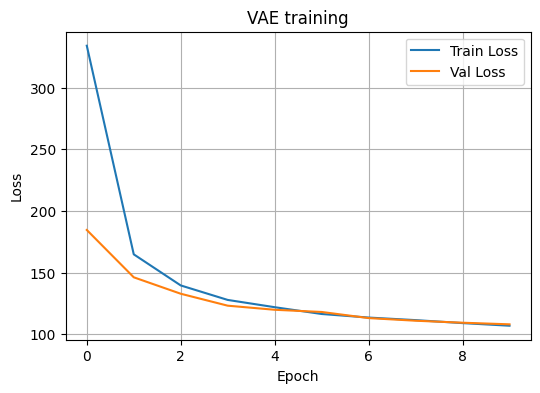

In [ ]:
history = train_model(Vae_model, train_loader, val_loader, device, epochs=10, lr=1e-3)
plot_training_history(history, title="VAE training")


The VAE shows a clear decrease in both training and validation loss across epochs, indicating stable convergence.  
The rapid drop during the first few epochs suggests that the model quickly learns a coarse reconstruction of the cat faces, while the slower improvement afterward reflects the fine-tuning of latent representations.  
Overall, the results confirm that the encoder–decoder architecture and the VAE loss are functioning correctly, with no signs of overfitting at this stage.

0.00824748631566763 0.9790204167366028 0.49600228667259216
0.00824748631566763 0.9790204167366028 0.49600228667259216
0.00824748631566763 0.9790204167366028 0.49600228667259216
0.00824748631566763 0.9790204167366028 0.49600228667259216
0.00824748631566763 0.9790204167366028 0.49600228667259216
0.00824748631566763 0.9790204167366028 0.49600228667259216
0.00824748631566763 0.9790204167366028 0.49600228667259216
0.00824748631566763 0.9790204167366028 0.49600228667259216


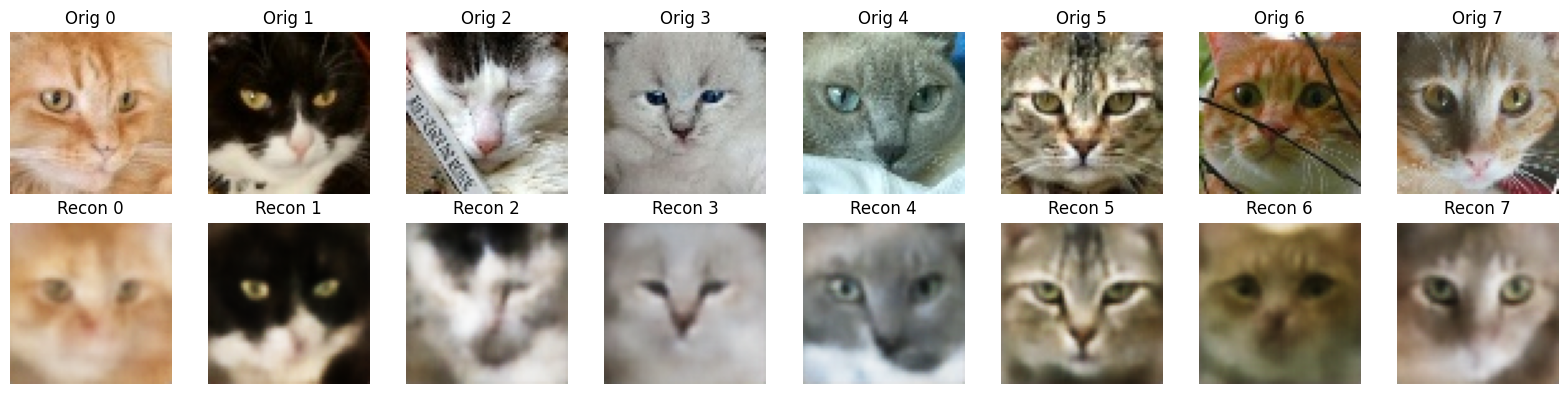

In [ ]:

Vae_model.eval()

# Nombre d'images à afficher
n = 8  

with torch.no_grad():
    # On récupère un batch de la validation
    batch = next(iter(val_loader))
    x = batch[0].to(device)             # (B, 3, 64, 64)

    # Passer dans le VAE
    x_recon, mu, logvar = Vae_model(x)  # (B, 3, 64, 64)

# On ne garde que les n premières et on repasse sur CPU
x = x[:n].cpu()
x_recon = x_recon[:n].cpu()

# Plot : ligne 1 = originales, ligne 2 = reconstructions
fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

for i in range(n):
    # Originale
    print(x_recon.min().item(), x_recon.max().item(), x_recon.mean().item())
    axes[0, i].imshow(x[i].permute(1, 2, 0).numpy())
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Orig {i}")

    # Reconstruction
    axes[1, i].imshow(x_recon[i].permute(1, 2, 0).numpy())
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Recon {i}")

plt.tight_layout()
plt.show()

## **Sampling new cat faces from the latent space**

Finally, we use the generative nature of the VAE to create **new synthetic cats**:

1. Sample latent vectors $(z \sim \mathcal{N}(0, I))$.
2. Pass them through the decoder to obtain images in $([0,1]^{64 \times 64 \times 3})$.
3. Display the generated samples in a grid.

These images are not copies from the dataset but new faces drawn from the
learned latent distribution.

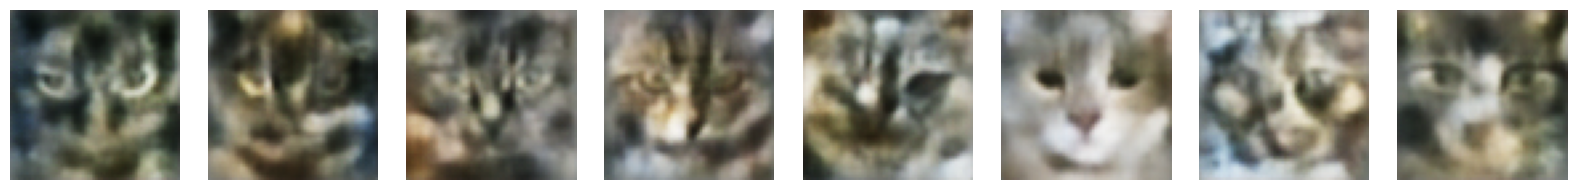

In [ ]:
Vae_model.eval()

n_samples = 8   # nombre de chats à générer
latent_dim = 128  # le même que celui utilisé pour ton VAE

with torch.no_grad():
    # z ~ N(0, I)
    z = torch.randn(n_samples, latent_dim).to(device)

    # Même pipeline que dans forward, mais sans encoder
    h_dec = Vae_model.fc_decode(z)                        # (n_samples, latent_dim*8*8)
    h_dec = h_dec.view(h_dec.size(0), latent_dim, 8, 8)   # (n_samples, latent_dim, 8, 8)
    samples = Vae_model.decoder(h_dec)                    # (n_samples, 3, 64, 64)

samples = samples.cpu()

# Affichage
fig, axes = plt.subplots(1, n_samples, figsize=(2*n_samples, 2))

for i in range(n_samples):
    axes[i].imshow(samples[i].permute(1, 2, 0).numpy())
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### **Saving the final VAE model**

To reuse the trained VAE later (for inference, comparison with other generative models, or for a separate evaluation notebook), we export the model weights using `torch.save`. This makes it easy to load the model without retraining.

In [ ]:
# Save trained VAE model
save_path = "../models/vae_cats.pth"
torch.save(Vae_model.state_dict(), save_path)
print(f"Model saved to {save_path}")